In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from scipy.sparse import hstack
import xgboost as xgb

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train = train.fillna(-1)

In [4]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,57.445890,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.111644,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,34.960241,9981.264932,1.382997,1.112799,30.202904,20.645407,180.734517,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,-1.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,-1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,42.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,63.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
cats = ['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 
        'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir',
        'Condition1', 'Condition2', 'Electrical', 'ExterCond', 
        'Exterior1st', 'Exterior2nd', 'ExterQual', 'Fence', 
        'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 
        'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 
        'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 
        'LandSlope', 'LotConfig', 'LotShape', 'MasVnrType', 
        'MiscFeature', 'MoSold', 'MSSubClass', 'MSZoning', 
        'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 
        'SaleCondition', 'SaleType', 'Street', 'Utilities']
nums = ['GarageYrBlt', 'LotFrontage', 'MasVnrArea', '1stFlrSF', 
        '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 
        'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 
        'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 
        'GarageArea', 'GarageCars', 'GrLivArea', 'HalfBath', 
        'KitchenAbvGr', 'LotArea', 'LowQualFinSF', 'MiscVal', 
        'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 
        'ScreenPorch', 'TotalBsmtSF', 'TotRmsAbvGrd', 
        'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']

In [6]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer().fit(train[cats].T.to_dict().values())
cat_matrix = dv.transform(train[cats].T.to_dict().values())

In [7]:
data_matrix = hstack([cat_matrix, train[nums]])

In [8]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()
poly_matrix = poly.fit_transform(data_matrix.toarray())

In [18]:
from sklearn.model_selection import GridSearchCV
boost = xgb.XGBRegressor()

n_estimators = range(350, 1050, 50)
tuned_parameters = dict(n_estimators=n_estimators)
grid = GridSearchCV(boost, tuned_parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid.fit(poly_matrix, train['SalePrice'])

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] n_estimators=350 ................................................
[CV] n_estimators=350 ................................................
[CV] n_estimators=350 ................................................
[CV] n_estimators=350 ................................................
[CV] ................................. n_estimators=350, total=12.0min
[CV] n_estimators=350 ................................................
[CV] ................................. n_estimators=350, total=12.0min
[CV] n_estimators=400 ................................................
[CV] ................................. n_estimators=350, total=12.0min
[CV] n_estimators=400 ................................................
[CV] ................................. n_estimators=350, total=12.0min
[CV] n_estimators=400 ................................................
[CV] ................................. n_estimators=350, total=11.2min
[CV] n_estimator

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 237.7min


[CV] ................................. n_estimators=650, total=20.1min
[CV] n_estimators=700 ................................................
[CV] ................................. n_estimators=650, total=20.1min
[CV] n_estimators=700 ................................................
[CV] ................................. n_estimators=700, total=21.4min
[CV] n_estimators=700 ................................................
[CV] ................................. n_estimators=700, total=19.8min
[CV] n_estimators=750 ................................................
[CV] ................................. n_estimators=700, total=19.8min
[CV] n_estimators=750 ................................................
[CV] ................................. n_estimators=700, total=19.8min
[CV] n_estimators=750 ................................................
[CV] ................................. n_estimators=700, total=19.8min
[CV] n_estimators=750 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 451.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=2)

In [28]:
from sklearn.model_selection import GridSearchCV
boost = xgb.XGBRegressor(n_estimators=550)

max_depth = range(1, 11, 2)
tuned_parameters = dict(max_depth=max_depth)
grid = GridSearchCV(boost, tuned_parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid.fit(poly_matrix, train['SalePrice'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] max_depth=1 .....................................................
[CV] max_depth=1 .....................................................
[CV] max_depth=1 .....................................................
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total= 6.4min
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total= 6.4min
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=1, total= 6.4min
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=1, total= 6.5min
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=1, total= 6.3min
[CV] max_depth=3 

[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 168.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=550, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 3, 5, 7, 9]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=2)

Best: -768758505.432098 using {'max_depth': 7}
-798886370.596863 (213810379.241077) with: {'max_depth': 1}
-777814214.362739 (230392603.032878) with: {'max_depth': 3}
-814792312.772266 (264392961.093708) with: {'max_depth': 5}
-768758505.432098 (226184756.743669) with: {'max_depth': 7}
-775380199.748565 (255437024.709269) with: {'max_depth': 9}


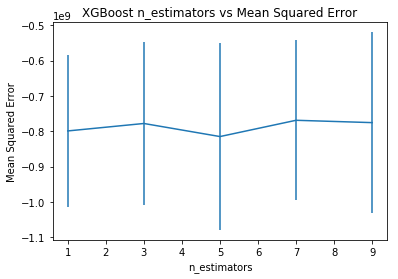

In [32]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(max_depth, means, yerr=stds) 
plt.title("XGBoost n_estimators vs Mean Squared Error") 
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')

In [ ]:
from sklearn.model_selection import GridSearchCV
boost = xgb.XGBRegressor()
n_estimators = [50, 100, 300, 400]
max_depth = [2, 4, 6, 8]
tuned_parameters = dict(max_depth=max_depth, n_estimators=n_estimators)
grid = GridSearchCV(boost, tuned_parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
grid.fit(poly_matrix, train['SalePrice'])

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] n_estimators=50, max_depth=2 ....................................
[CV] n_estimators=50, max_depth=2 ....................................
[CV] n_estimators=50, max_depth=2 ....................................
[CV] n_estimators=50, max_depth=2 ....................................


In [33]:
%%time
boost = xgb.XGBRegressor(n_estimators=550, max_depth=7)
boost = boost.fit(poly_matrix, train['SalePrice'])

CPU times: user 22min 43s, sys: 2.59 s, total: 22min 46s
Wall time: 22min 47s


In [34]:
train_preds = boost.predict(poly_matrix)

In [35]:
from sklearn.metrics import mean_squared_error
print mean_squared_error(train['SalePrice'], train_preds)**0.5

205.200783502


In [36]:
test = test.fillna(-1)
test_matrix = dv.transform(test[cats].T.to_dict().values())
test_data_matrix = hstack([test_matrix, test[nums]])
test_poly = poly.transform(test_data_matrix.toarray())

In [37]:
preds = boost.predict(test_poly)

In [38]:
submission = pd.DataFrame()
submission['Id'] = test.Id
submission['SalePrice'] = preds

In [39]:
submission.to_csv('submission_xgb.csv', index=False)